In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

__Things to add:__

1. name parameter in tf: https://stackoverflow.com/questions/33648167/why-do-we-use-name-parameter-when-creating-a-variable-in-tensorflow

An implicit graph is already existing after importing tf:

In [4]:
graph = tf.get_default_graph()

`get_operations` can output operations in a graph:

In [7]:
graph.get_operations()    # currently empty

[]

## Example 0: TF tricks

Some discussions on sess.run() vs X.eval:

- `sess.run` fetches all tensors vs `eval` fetches only the tensor that is calling (so faster?): https://www.quora.com/What-is-the-difference-of-eval-and-sess-run-in-TensorFlow
- https://stackoverflow.com/questions/33610685/in-tensorflow-what-is-the-difference-between-session-run-and-tensor-eval

In [3]:
x = tf.constant(10, dtype = tf.float32, name='input')

In [4]:
w = tf.Variable(0.8, name='weight')

In [5]:
y = tf.multiply(w, x, name='output')

In [24]:
print(x)

Tensor("input_3:0", shape=(), dtype=float32)


In [8]:
sess = tf.Session()
?tf.
summary_writer = tf.summary.FileWriter('log_simple_stats', sess.graph)

AttributeError: module 'tensorflow.python.training.training' has no attribute 'SummaryWriter'

In [7]:
init = tf.global_variables_initializer()
sess.run(init)

In [32]:
print(sess.run(y))

8.0


In [1]:
x.eval(session = sess)

NameError: name 'x' is not defined

In [34]:
summary_writer = tf.train.SummaryWriter('log_simple_graph', sess.graph)

AttributeError: module 'tensorflow.python.training.training' has no attribute 'SummaryWriter'

## Example 1: Use TF to do back-prop

Writing and running programs in TensorFlow has the following steps:

1. Create Tensors (variables) that are not yet executed/evaluated. 
2. Write operations between those Tensors.
3. Initialize your Tensors. 
4. Create a Session. 
5. Run the Session. This will run the operations you'd written above. 

The following blocks initialize the variables and the computation graphs:

In [154]:
# assign a variable whose values are customizable
coefficients = np.array([[1], [-20], [25]])

In [155]:
# define a tf variable, of which value to be found to minimize the cost function
w = tf.Variable([0], dtype = tf.float32)

In [156]:
x = tf.placeholder(tf.float32, [3, 1])

When we created a variable for the loss, we simply defined the loss as a function of other quantities, but did not evaluate its value. To evaluate it, we had to run `init=tf.global_variables_initializer()`. That initialized the loss variable, and in the last line we were finally able to evaluate the value of `loss` and print its value.

In [157]:
cost = x[0][0]*w**2 + x[1][0]*w + x[2][0]
train = tf.train.GradientDescentOptimizer(0.01).minimize(cost)
init = tf.global_variables_initializer()

The following creates a session and run the operations inside the session:

In [158]:
with tf.Session() as session:
    # Run the variables initialization 
    session.run(init)
    # Run the oput of w, which is 0 since no operation is conducted
    print(session.run(w))
    
    # run GD for one step, and print the output
    session.run(train, feed_dict={x:coefficients})
    print(session.run(w))
    
    # This takes care of closing the session

[ 0.]
[ 0.19999999]


In [159]:
w.eval(session = session)

RuntimeError: Attempted to use a closed Session.

In [102]:
with tf.Session() as session: 
    # Run the variables initialization 
    session.run(init)
    # run GD for 1000 steps
    for i in range(1000):
        session.run(train, feed_dict={x:coefficients})
    print(session.run(w))

[ 9.99997711]


## Example 2: Use TF to build a FFN to predict number in MNIST data

In [140]:
# load the mnist input data
from tensorflow.examples.tutorials.mnist import input_data

In [141]:
# define the initial weights
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

In [142]:
def model(X, w_h, w_o):
    h = tf.nn.sigmoid(tf.matmul(X, w_h)) # this is a basic mlp, think 2 stacked logistic regressions
    return tf.matmul(h, w_o) # note that we dont take the softmax at the end because our cost fn does that for us

In [143]:
# read_data_sets will download the data (if not exists in local), unzip it, and turn it into one_hot matrix
# use the fashion data

mnist = input_data.read_data_sets("data/fashion", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

X = tf.placeholder("float", [None, 784])  # input X for each data is a vector of length 784 (28*28)
Y = tf.placeholder("float", [None, 10])   # each Y has 10 labels

w_h = init_weights([784, 625]) # create symbolic variables
w_o = init_weights([625, 10])

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [144]:
py_x = model(X, w_h, w_o)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x, labels=Y)) # compute costs
train_op_gd = tf.train.GradientDescentOptimizer(0.05).minimize(cost) # construct an optimizer using gradient descent
train_op_adam = tf.train.AdamOptimizer(0.05, beta1=0.9, beta2=0.999, 
                                       epsilon=1e-08).minimize(cost)  # optimizer using Adam
train_op_rmsprop = tf.train.RMSPropOptimizer(0.05, decay=0.9, 
                                             momentum=0.0, epsilon=1e-10, use_locking=False, 
                                             centered=False, name='RMSProp')  # RMSProp
predict_op = tf.argmax(py_x, 1)

In [124]:
?tf.argmax

In [145]:
def ffn_mnist(method = "gd", learning_rate = 0.05):
    """
    method = "gd" (gradient descent), "adam", "rmsprop"
    """
    
    py_x = model(X, w_h, w_o)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x, labels=Y)) # compute costs
    train_op_gd = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost) # construct an optimizer using gradient descent
    train_op_adam = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999, 
                                           epsilon=1e-08).minimize(cost)  # optimizer using Adam
    train_op_rmsprop = tf.train.RMSPropOptimizer(learning_rate, decay=0.9, 
                                                 momentum=0.0, epsilon=1e-10, use_locking=False, 
                                                 centered=False, name='RMSProp')  # RMSProp
    predict_op = tf.argmax(py_x, 1)
    
    if method == "gd":
        train_op = train_op_gd
    elif method == "rmsprop":
        train_op = train_op_rmsprop
    elif method == "adam":
        train_op = train_op_adam
            
    precision = []

    # Launch the graph in a session
    with tf.Session() as sess:
        # you need to initialize all variables
        tf.global_variables_initializer().run()

        for i in range(100):
            for start, end in zip(range(0, len(trX), 128), range(128, len(trX)+1, 128)):
                sess.run(train_op_adam, feed_dict={X: trX[start:end], Y: trY[start:end]})
            if i % 10 == 0:
                print("Accuracy after epoch %i: %f" % (i, np.mean(np.argmax(teY, axis=1) ==
                             sess.run(predict_op, feed_dict={X: teX}))))
            precision.append(np.mean(np.argmax(teY, axis=1) ==
                             sess.run(predict_op, feed_dict={X: teX})))    # plot the precision
        return precision

**The batch gradient descent:**

In [146]:
precision_gd = ffn_mnist(method = "gd", learning_rate = 0.01)

Accuracy after epoch 0: 0.841400
Accuracy after epoch 10: 0.848300
Accuracy after epoch 20: 0.863400
Accuracy after epoch 30: 0.864900
Accuracy after epoch 40: 0.849900
Accuracy after epoch 50: 0.854000
Accuracy after epoch 60: 0.862800
Accuracy after epoch 70: 0.865600
Accuracy after epoch 80: 0.864600
Accuracy after epoch 90: 0.857800


In [152]:
print(precision_gd[99])

0.8588


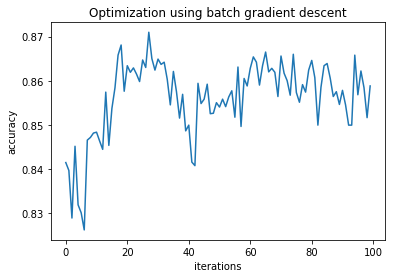

In [147]:
plt.plot(np.squeeze(precision_gd))
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.title('Optimization using batch gradient descent')
plt.show()

**Using Adam optimization:**

In [148]:
precision_adam = ffn_mnist(method = "adam", learning_rate = 0.01)

Accuracy after epoch 0: 0.836300
Accuracy after epoch 10: 0.848400
Accuracy after epoch 20: 0.853800
Accuracy after epoch 30: 0.852600
Accuracy after epoch 40: 0.854900
Accuracy after epoch 50: 0.857400
Accuracy after epoch 60: 0.858700
Accuracy after epoch 70: 0.860000
Accuracy after epoch 80: 0.849600
Accuracy after epoch 90: 0.865200


In [153]:
print(precision_adam[99])

0.8626


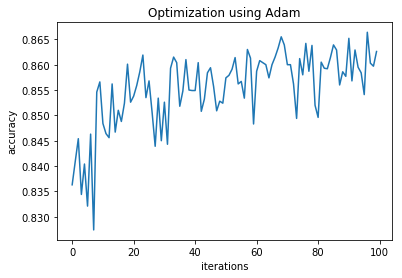

In [150]:
plt.plot(np.squeeze(precision_adam))
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.title('Optimization using Adam')
plt.show()

In [138]:
precision_rmsprop = ffn_mnist(method = "rmsprop", learning_rate = 0.01)

Accuracy after epoch 0: 0.955800
Accuracy after epoch 10: 0.969600
Accuracy after epoch 20: 0.975600
Accuracy after epoch 30: 0.973800
Accuracy after epoch 40: 0.973300
Accuracy after epoch 50: 0.974800
Accuracy after epoch 60: 0.975600
Accuracy after epoch 70: 0.977800
Accuracy after epoch 80: 0.974600
Accuracy after epoch 90: 0.978000


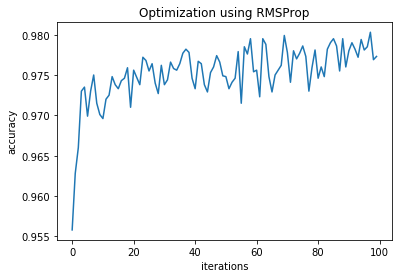

In [139]:
plt.plot(np.squeeze(precision_rmsprop))
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.title('Optimization using RMSProp')
plt.show()